In [37]:
'''
Visualize impedance measurement of BioTac
Author: Yitian Shao
Created on 2022.07.08
'''

from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Arc
import pandas as pd
from scipy import signal
from scipy.interpolate import griddata
import seaborn as sns

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='0.5', linewidth=0.75)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rcParams.update({'errorbar.capsize': 4})

figSize_inch = (3.2, 2.4)

In [26]:
'''
General Functions
'''
def decodeActuatorInfo(rootName):
    actLabel = re.findall('Act\d+mm\d+\.\d+mL', rootName)
    if actLabel:
        actLabel = actLabel[0]
    return actLabel

def decodeData(fileName, numFormat, frontCode='', rearCode=''):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

In [185]:
'''
Class
'''
class BiotacMap:
    ''' Class of biotac mapping for impedance data visualization '''
    def __init__(self):
        ''' Biotac Electrode 1-19 layout '''
        eXY = [[278, 523], [226, 588], [226, 639], [278, 666], [226, 704], [278, 757],
               [174, 458], [213, 497], [135, 497], [174, 536], [69, 523], [122, 588],
               [122, 639], [69, 665], [122, 704], [69, 756], [174, 587], [174, 691], [174, 756]]
        eXY = np.array(eXY)
        eXY[:,1] = -eXY[:,1]+800

        self.eXY = eXY
        self.eNum = eXY.shape[0]
        
        extent = (50,300,0,400)
        self.extent = extent
        
        self.grid_x, self.grid_y = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]]
        
        ''' Finger-shape mapping: Set electrode 10 eXY[9,:] as the arc center of the shape '''
        self.centerX = btMap.eXY[9,0]
        self.centerY = btMap.eXY[9,1]
        self.bottomY = btMap.eXY[18,1] - 20
        self.cRadius = 125

        ''' Biotac finger shape '''
        grid_x, grid_y = np.mgrid[(centerX-cRadius):(centerX+cRadius), bottomY:(centerY+cRadius)]
        gridXY = np.vstack((grid_x.flatten(),grid_y.flatten())).T

        ind = (gridXY[:,1] <= centerY) | ((gridXY[:,1] > centerY) & 
              ((np.square(gridXY[:,0]-centerX) + np.square(gridXY[:,1]-centerY)) < (cRadius*cRadius)))
        self.gridXY = gridXY[ind,:]
        
    ''' Compute distance map '''    
    def initializeDistanceMap(self, alpha=100): # Alpha determine the smoothness of the map: Phi = 1/(dist + Alpha)
        distMap = []
        for i in range(btMap.eNum):
            distMap.append(np.sqrt(np.square(gridXY[:,0]-btMap.eXY[i,0]) + np.square(gridXY[:,1]-btMap.eXY[i,1])))
            
        self.distMap = np.array(distMap)

        self.Phi = 1 / (self.distMap + alpha)
        
        self.SumPhi = np.sum(self.Phi, axis=0)
    
    def dispElectrode(self, ax, s=100, fontsize=5, fontcolor='w'):
        for ei in range(self.eNum):
            ax.scatter(self.eXY[ei,0], self.eXY[ei,1], s=s, c='darkslategrey')
            ax.text(self.eXY[ei,0]-12, self.eXY[ei,1]-5, ("E%d" % (ei+1)), fontsize=fontsize, color=fontcolor)
        ax.axis('equal')
    
    def dispFingerLayout(self, ax):
        arcObj = Arc([self.centerX, self.centerY], 2*self.cRadius, 2*self.cRadius, angle=0, theta1=0.0, 
                theta2=180.0, color='turquoise', lw=1)
        ax.add_patch(arcObj)
        ax.plot([self.centerX-self.cRadius, self.centerX-self.cRadius], [self.bottomY, self.centerY], color='turquoise', lw=1)
        ax.plot([self.centerX+self.cRadius, self.centerX+self.cRadius], [self.bottomY, self.centerY], color='turquoise', lw=1)
        ax.plot([self.centerX-self.cRadius, self.centerX+self.cRadius], [self.bottomY, self.bottomY], color='turquoise', lw=1)
        ax.axis('equal')
        
    def dispFingerSurface(self, ax):
        ax.plot(self.gridXY[:,0], self.gridXY[:,1], color='turquoise', lw=0.1)
        
    def constructMap(self, ax, eValue, cmap=cm.get_cmap('viridis', 100), s=0.1, dispOutline=False):
        values = np.matmul(eValue, self.Phi) / self.SumPhi
        
        values = ((values-np.amin(values)) / (np.amax(values)-np.amin(values))) # Normalize values

        ax.scatter(self.gridXY[:,0], self.gridXY[:,1], c=values, cmap=cmap, s=s, norm=plt.Normalize(0,1))
        
        ax.axis('equal')
        ax.axis('off')
        
        if dispOutline:
            self.dispFingerLayout(ax)
        
    def constructMapCubic(self, ax, eValue, dispNode=False): # (Obsolete) Interpolation cubically between electrodes 
        grid_z = griddata(self.eXY, eValue, (self.grid_x, self.grid_y), method='cubic')
        
        ax.imshow(grid_z.T, extent=self.extent, origin='lower', cmap='gray')
        
        if dispNode:
            self.dispElectrode(ax)
        ax.axis('off')

(36.5, 311.5, 5.75, 407.25)

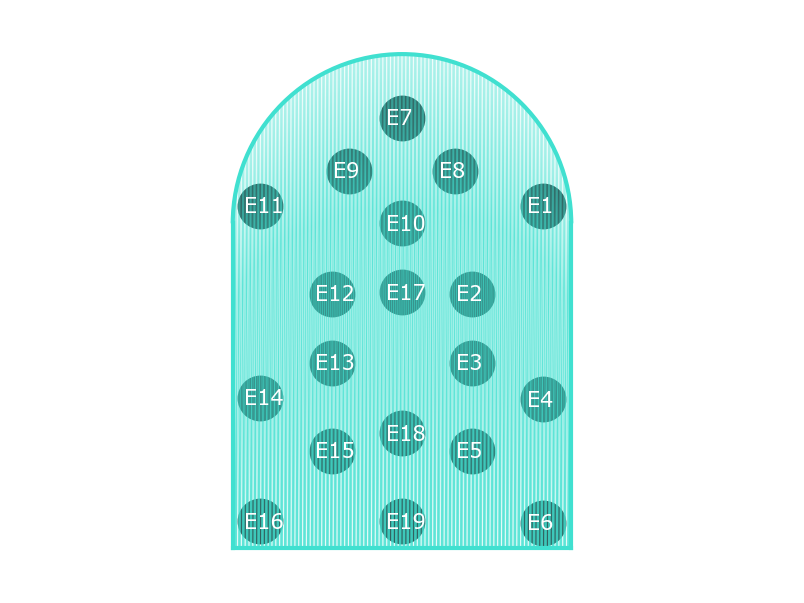

In [189]:
''' Pesudo test data'''
# eValue = np.random.rand(19,)
eValue = np.zeros(19,)

btMap = BiotacMap()
btMap.initializeDistanceMap()

fig1, ax = plt.subplots(dpi=300, figsize=figSize_inch)

# btMap.constructMap(ax, eValue, dispOutline=True)
btMap.dispFingerSurface(ax)
btMap.dispFingerLayout(ax)
btMap.dispElectrode(ax)
ax.axis('off')

# btMap.constructMapCubic(ax, eValue, dispNode=True)



L110F1.8V100C0400D4000 --- Len=110mm, Infill=1.8mL, Condi: v=100% c=400ms d=4000ms t=1
Selected time instance at 1.67 sec, index = 167


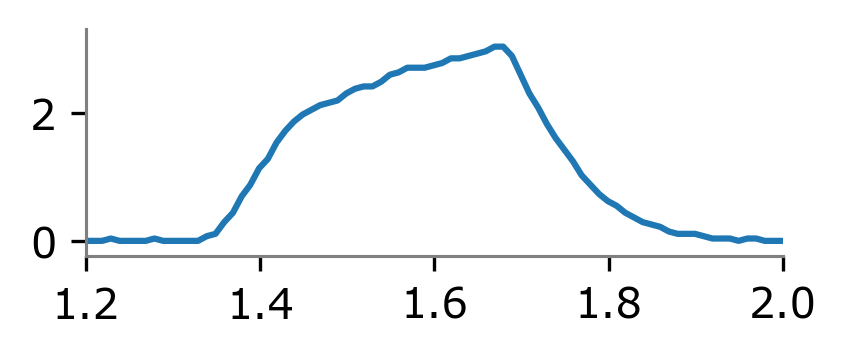

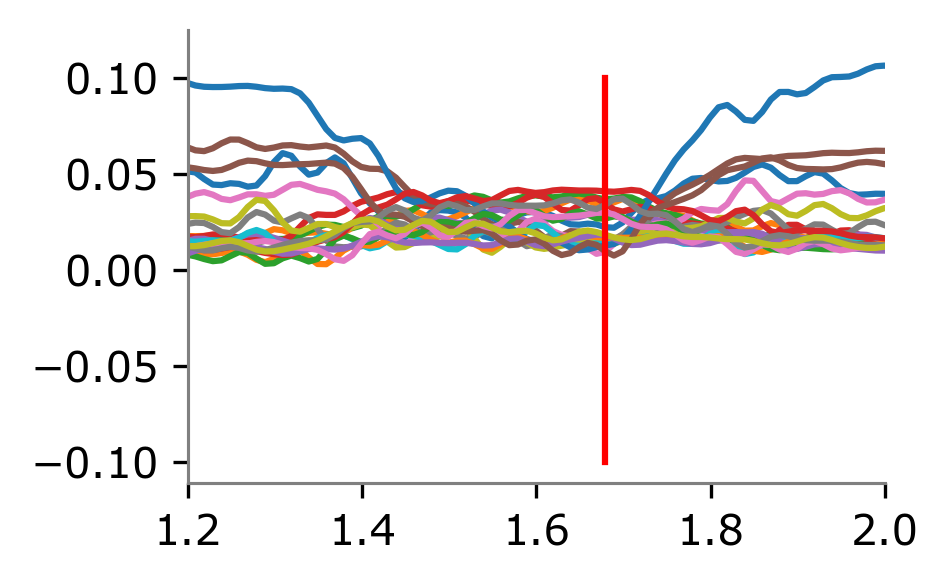

In [14]:
''' Visualize real data '''
Fs = 100

measureDataPath = ".\Data2022.06.26"
root = 'Act110mm1.8mL'
fileName = 'v100c400d4000t1.btd.csv'

actLabel = decodeActuatorInfo(root)

if actLabel:
    tubeLen = decodeData(actLabel, '\d+', rearCode='mm')
    infillVol = decodeData(actLabel, '[\d+\.]*\d+', rearCode='mL')   

    vLevel = decodeData(fileName, '\d+', frontCode='v')
    cTime = decodeData(fileName, '\d+', frontCode='c')
    dTime = decodeData(fileName, '\d+', frontCode='d')
    trialNum = decodeData(fileName, '\d+', frontCode='t')
    dLabel = "L%03dF%.1fV%03dC%04dD%04d" % (tubeLen, infillVol, vLevel, cTime, dTime)  
    
    print("%s --- Len=%dmm, Infill=%.1fmL, Condi: v=%d%% c=%dms d=%dms t=%d" % 
          (dLabel, tubeLen, infillVol, vLevel, cTime, dTime, trialNum))         

''' Read in data '''
data = np.genfromtxt(ospa.join(measureDataPath, root, fileName), delimiter=',')

t = data[:,0]
pDC = (data[:,1] - data[0,1]) * 0.0365 # DC Pressure = (Pdc - Offset) 0.0365 kPa/bit
tAC = data[:,2]
tDC = data[:,3]
eData = (4095/data[:,4:] - 1) * 10 # Impedance = (4095/En - 1) 10 kOhm
# eData = eData - eData[0,:]
# eData = eData - np.amin(eData)
eData = eData - np.amin(eData, axis=0)

''' Smooth impedance signal '''
for i in range(19):
    eData[:,i] = lowpassSmooth(eData[:,i], cutFreqRatio = 0.2, order = 8)

''' Exam data '''
tRange = [1.2, 2]

tInstance = 1.67 #1.32 #1.67

ti = np.argmax(t>=tInstance)
print("Selected time instance at %.2f sec, index = %d" % (tInstance, ti))

# _,(ax1, ax2, ax3)  = plt.subplots(3, 1, dpi=300, figsize=(3,2))
_,ax1 = plt.subplots(dpi=300, figsize=(3,1))
ax1.plot(t, pDC)
# ax1.plot(t[[ti, ti]], [0, 3], 'r')
ax1.set_xlim(tRange)
# ax2.plot(t, tAC)
# ax2.set_xlim(tRange)
# ax3.plot(t, tDC)
# ax3.set_xlim(tRange)

fig1, ax = plt.subplots(dpi=300, figsize=(3,2))
for i in range(19):
    ax.plot(t, eData[:,i])
ax.set_xlim(tRange)
ax.plot(t[[ti, ti]], [-0.1, 0.1], 'r')


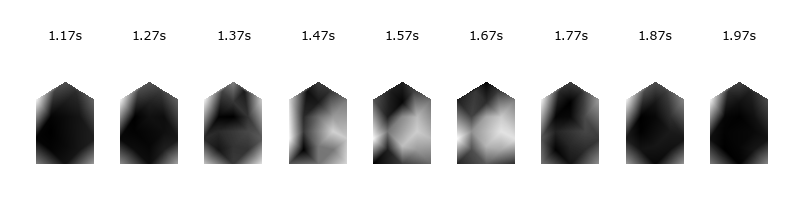

In [15]:
''' Visualize Biotac electrode impedance map '''
btMap = BiotacMap()

tind = np.arange(116,198,10)
frameNum = len(tind)

fig1, axes = plt.subplots(1, frameNum, dpi=300, figsize=figSize_inch)
for i in range(frameNum):
    btMap.constructMap(axes[i], eData[tind[i],:])
    axes[i].set_title("%.2fs" % t[tind[i]], size=3)

In [43]:
''' Smooth interpolation of impedance map '''





' Smooth interpolation of impedance map '